## Prepare

In [4]:
! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar?ts=gAAAAABk1grVPN66UoxuyfsRPvuzhgnmeEB0y0aRIsA3TRrksaUWqajBjQ-E21zbKyJzhrCcIYFh6YpJanCBPWJlAoXzemk3Rg%3D%3D&r=https%3A%2F%2Fsourceforge.net%2Fprojects%2Fdacapobench%2Ffiles%2F9.12-bach-MR1%2Fdacapo-9.12-MR1-bach.jar
! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
# ! java -version

--2023-08-21 14:01:53--  https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
Resolving download.bell-sw.com (download.bell-sw.com)... 104.18.0.179, 104.18.1.179, 2606:4700::6812:1b3, ...
Connecting to download.bell-sw.com (download.bell-sw.com)|104.18.0.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208827956 (199M) [application/x-gzip]
Saving to: ‘jdk.tar.gz’

jdk.tar.gz            1%[                    ]   2,07M  2,50MB/s               ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
! ./jdk-11.0.20/bin/java -jar dacapo-bench.jar -l

avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan


In [ ]:
! BM=batik & ./jdk-11.0.20/bin/java -XX:+UseParallelGC -XX:MaxHeapSize=42983227392 -cp dacapo-bench.jar \
-Xlog:gc=debug:file=gc-{BM}.txt -Dvmstat.enable_jfr=yes \
-Dvmstat.csv=yes Harness -v -n 5 {BM}

Class name: org.dacapo.harness.Batik
Configurations:
short     A Scalable Vector Graphics (SVG) toolkit
long      A Scalable Vector Graphics (SVG) toolkit that renders a number of svg files. It usess additional threads to speed the rendering or transcoding process.
author    null
license   Apache License, Version 2.0
copyright Copyright (C) 2000 The Apache Software Foundation
url       http://xml.apache.org/batik/
version   1.7
sizes     default large small
Using a single thread to drive the workload.
===== DaCapo 9.12-MR1 batik starting warmup 1 =====
About to transcode 3 SVG file(s)

Converting mapWaadt.svg to /home/ellkrauze/projects/gc-ml/./scratch/mapWaadt.png ... ... success
Converting mapSpain.svg to /home/ellkrauze/projects/gc-ml/./scratch/mapSpain.png ... ... success
Converting sydney.svg to /home/ellkrauze/projects/gc-ml/./scratch/sydney.png ... java.lang.reflect.InvocationTargetException
java.lang.reflect.InvocationTargetException
	at java.base/jdk.internal.reflect.NativeMet

In [ ]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


## Main

In [1]:
! export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import os
import re
import sys
import gym
import random
import requests
import json
import subprocess
import logging
import warnings
import numpy as np
from typing import List
from gym.spaces import Discrete, Box

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

import JVMEnv, JVMEnvTest
from tqdm import tqdm 

import tensorflow as tf
print(tf.__version__)

warnings.filterwarnings(action="ignore")

# GCEasy API Key
API_KEY = "af176fbc-7be2-4fc5-8b31-5624956845c6"

# JDK used for benchmarking
TEST_JDK_PATH = "/home/ellkrauze/projects/gc-ml/jdk-11.0.20"

# DaCapo benchmark name
BM = "batik"

BM_PATH = "dacapo-bench.jar"

# Number of benchmark's iterations in total
NUM_ITER = 5

# Name of the output file (Garbage Collector logs)
GC_LOG_FILE = f"gc-{BM}.txt"

# JVM option to perform action to (increase, leave, decrease)
JVM_OPT_NAME = "MaxHeapSize"
# Maximum heap size array (from 256m to 4G)
JVM_OPT_RANGE = [np.array([268435456]), np.array([4294967296])]

"""
What to optimize: our goal in performance tuning.
This is a JSON field which is extracted from GC log file
using GCEasy API (https://blog.gceasy.io/2016/06/18/garbage-collection-log-analysis-api/).
"""
# GOAL = "throughputPercentage"
GOAL = "fullGCMaxTime"

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    # model.add(Flatten())
    return model
    
def build_callbacks(env_name):
    checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

2023-08-21 17:23:39.348474: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2023-08-21 17:23:39.348499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.3.0


In [3]:
# env = JVMEnv.JVMEnv(
#     jdk = TEST_JDK_PATH, 
#     bm_path = BM_PATH,
#     jvm_opt_name = JVM_OPT_NAME,
#     jvm_opt_range = JVM_OPT_RANGE,
#     bm = BM,
#     n = NUM_ITER,
#     goal = GOAL,
#     api_key = API_KEY
# )

## Plot Xmx

In [ ]:

fullgc_values = []
minorgc_values = []
heap_values = []

for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
    env._run(
        jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
        gc_log_file = GC_LOG_FILE, 
        bm = BM, 
        bm_path = BM_PATH, 
        n = NUM_ITER
    )
    
    fullgc_value = env._get_goal_value(
        goal_name = "fullGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    minorgc_value = env._get_goal_value(
        goal_name = "minorGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    fullgc_values.append(fullgc_value)
    minorgc_values.append(minorgc_value)
    heap_values.append(Xmx)

100%|██████████| 39/39 [06:48<00:00, 10.47s/it]


100%|██████████| 39/39 [01:50<00:00,  2.83s/it]


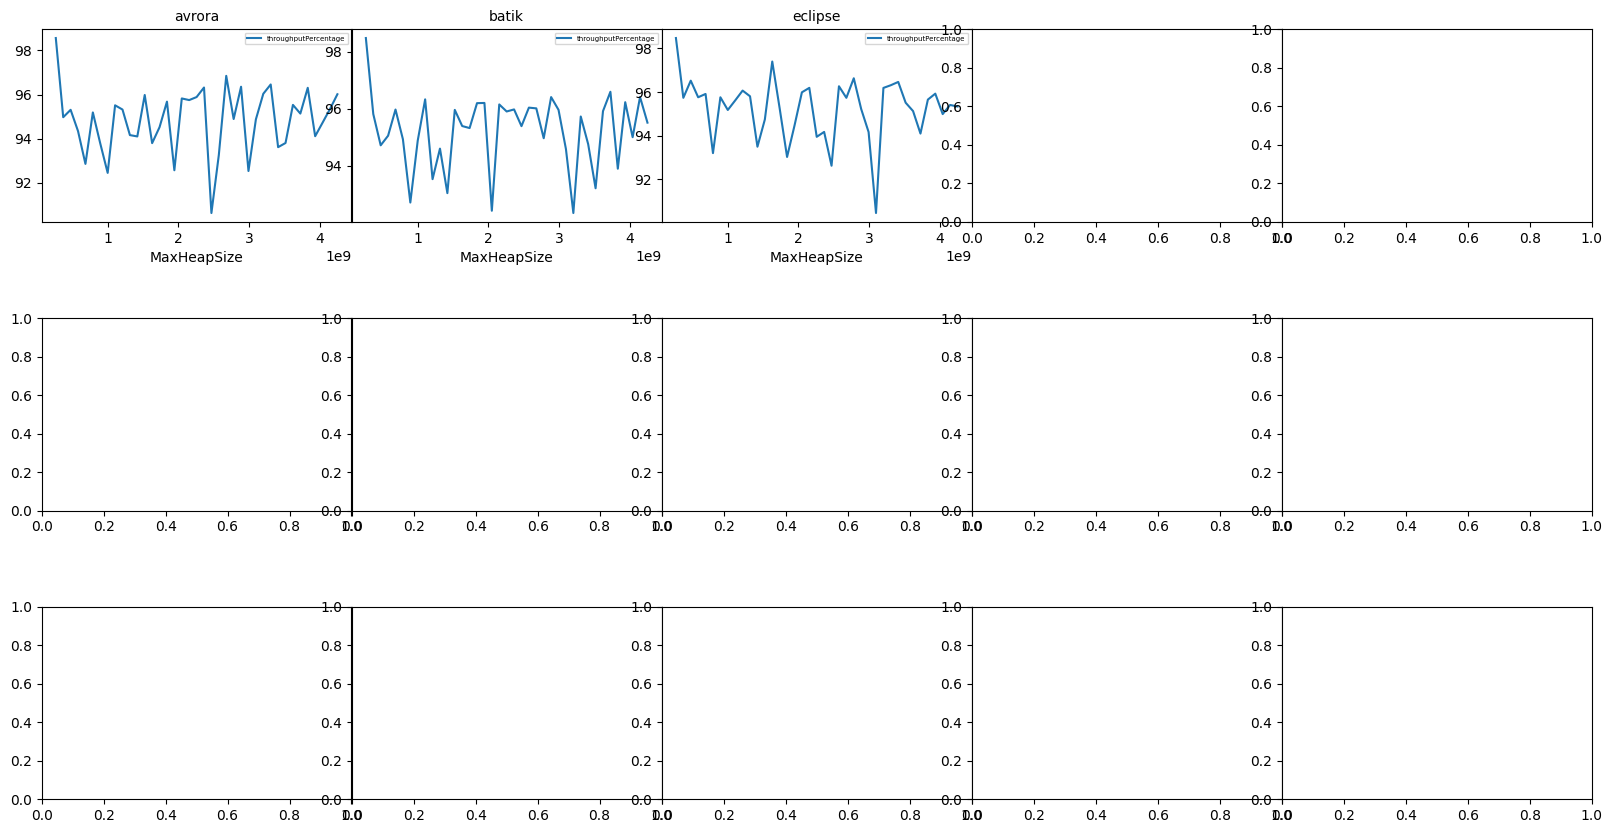

In [ ]:
def get_goal_value(goal_name: str, gc_log_file: str, api_key: str, verbose: bool=False):

    gceasy_url = f"https://api.gceasy.io/analyzeGC?apiKey={api_key}&normalizeUnits=true"
    gc_logfile = {"upload_file": open(gc_log_file, 'rb')}
    headers = {"Content-Type": "text"}

    response = requests.post(gceasy_url, files=gc_logfile, headers=headers)
    gc_info = json.loads(response.text)
    goal_value = gc_info[goal_name]

    if verbose: logging.debug(f"{goal_name} = {goal_value}")

    return float(goal_value)

bms = ["avrora","batik","eclipse", "fop", "h2", "jython", "luindex", "lusearch", "lusearch-fix", "pmd", "sunflow", "tomcat", "tradebeans", "tradesoap", "xalan"]

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

# for i in range(len(bms)):
for i in range(3):

    # Measurements
    gc_values = []
    heap_values = []

    for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
        env._run(
            jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
            gc_log_file = GC_LOG_FILE, 
            bm = BM, 
            bm_path = BM_PATH, 
            n = 3
        )
        
        gc_value = get_goal_value(
            goal_name = "throughputPercentage", 
            gc_log_file = GC_LOG_FILE, 
            api_key = API_KEY
        )

        gc_values.append(gc_value)
        heap_values.append(Xmx)
    
    # Plots
    axs[i].plot(heap_values, gc_values, label='throughputPercentage')
    axs[i].legend(fontsize = 5)
    axs[i].set_xlabel(JVM_OPT_NAME, fontsize = 10)
    axs[i].set_title(bms[i], fontsize = 10)

# plt.plot(heap_values, fullgc_values, label='minorGCMaxTime')
# plt.plot(heap_values, minorgc_values, label='fullGCMaxTime')
# plt.legend()
# plt.xlabel(JVM_OPT_NAME)
# plt.title(BM)
# plt.show()

## Deep Learning Model

In [2]:
env = JVMEnvTest.JVMEnvTest()

states = env.observation_space.shape
actions = env.action_space.n

print(states)
print(actions)

model = build_model(states, actions)
model.summary()

(2,)
2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________


In [ ]:
episodes = 3
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
        print(info)
        print(f"Score: {score}")
    print('Episode:{} Score:{}'.format(episode, score))

In [3]:
callbacks = build_callbacks("gc")

policy = BoltzmannQPolicy()
# memory = SequentialMemory(limit=50000, window_length=1)

# memory can help a model during training
# for this, we only consider a single malware sample (window_length=1) for each "experience"
memory = SequentialMemory(limit=1000, window_length=1)

# DQN agent as described in Mnih (2013) and Mnih (2015).
# http://arxiv.org/pdf/1312.5602.pdf
# http://arxiv.org/abs/1509.06461
dqn = DQNAgent(
    model=model, 
    memory=memory, 
    policy=policy,
    nb_actions=actions, 
    nb_steps_warmup=10, 
    target_model_update=1e-2, 
    batch_size=16,
    gamma=.99
)

# keras-rl allows one to use and built-in keras optimizer
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

2023-08-21 17:23:44.621352: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-08-21 17:23:44.659684: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-21 17:23:44.659708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ellkrauze-desktop): /proc/driver/nvidia/version does not exist
2023-08-21 17:23:44.660394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 17:23:44.681646: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3793000000 Hz
2023-08-21 17:23:44.682495: I te

Training for 50000 steps ...
Interval 1 (0 steps performed)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
10000/10000 [==============================] - 35s 3ms/step - reward: 6.9020
3 episodes - episode_reward: 463.731 [12.417, 1338.193] - loss: 0.535 - mae: 51.321 - mean_q: 235.935

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 7.0366
4 episodes - episode_reward: 30962.728 [-0.796, 123763.750] - loss: 150.322 - mae: 130.135 - mean_q: 525.165

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 7.0417
Interval 4 (30000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 7.0417
Interval 5 (40000 steps performed)
10000/10000 [==============================] - 33s 3ms/step - reward: 7.0417
done, took 167.816 seconds


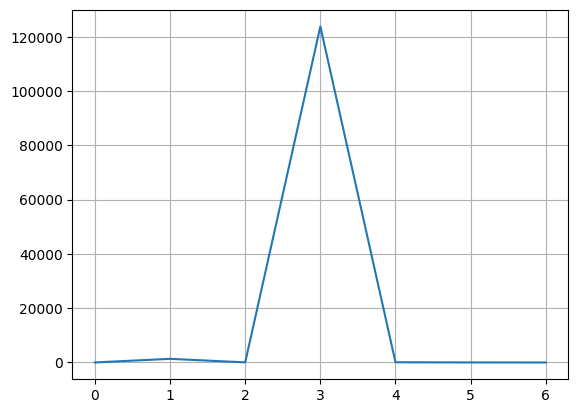

In [4]:
import matplotlib.pyplot as plt 
plt.grid(True)
plt.plot(history.history['episode_reward'])

In [ ]:
# scores = dqn.test(env, nb_episodes=100, visualize=False)

scores = dqn.test(
    env, 
    nb_episodes=1,
    visualize=False, 
    verbose=1
)

# print(np.mean(scores.history['episode_reward']))

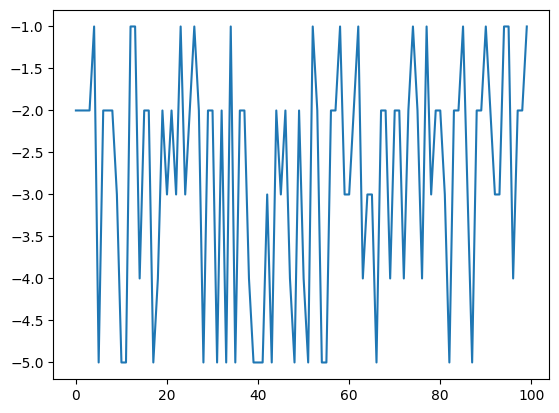

In [7]:
import matplotlib.pyplot as plt 
plt.plot(scores.history['episode_reward'])

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

## Save and load

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
# env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

## Parameters

* ParallelGCThreads: int
* MaxGCPauseMillis: int
* GCTimeRatio: int
* MaxHeapSize: int
* InitialHeapSize: int
* YoungGenerationSizeIncrement: int
* TenuredGenerationSizeIncrement: int
* AdaptiveSizeDecrementScaleFactor: int
* ParallelGCBufferWastePct: int
* ParallelOldDeadWoodLimiterMean: int
* ParallelOldDeadWoodLimiterStdDev: int
* PreTouchParallelChunkSize: int

* UseGCOverheadLimit: bool
* ParallelRefProcBalancingEnabled: bool
* ParallelRefProcEnabled: bool
* AllowParallelDefineClass: bool
* CMSParallelInitialMarkEnabled: bool
* CMSParallelRemarkEnabled: bool
* CMSParallelSurvivorRemarkEnabled: bool
* GCParallelVerificationEnabled: bool